# Initialize Packages

In [1]:
%pip install pandas matplotlib seaborn scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Imports for ML tasks
# Ensure xgboost is installed in this notebook environment (fixes "Import could not be resolved")
%pip install xgboost --quiet
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data & numerical
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Preprocessing & model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# Optional - try to import if available
try:
    import xgboost as xgb
except Exception:
    xgb = None

# Print key library versions for reproducibility
print(f"numpy={np.__version__}, pandas={pd.__version__}, scikit-learn={__import__('sklearn').__version__}, matplotlib={__import__('matplotlib').__version__}, seaborn={sns.__version__}")


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
numpy=2.4.0, pandas=2.3.3, scikit-learn=1.8.0, matplotlib=3.10.8, seaborn=0.13.2


# Initialize Datasets

In [4]:
train_data = pd.read_csv("titanic_train.csv")
test_data = pd.read_csv("titanic_test.csv")

columns_to_drop = ["Name", "Cabin", "Ticket"]
train_data = train_data.drop(columns=columns_to_drop, errors='ignore')
test_data = test_data.drop(columns=columns_to_drop, errors='ignore')

In [5]:
# Impute missing fare
train_data = train_data.replace({"Fare": np.nan}, train_data["Fare"].median())
test_data = test_data.replace({"Fare": np.nan}, test_data["Fare"].median())

# Impute missing ages
age_imputer = SimpleImputer(strategy='median')
train_data['Age'] = age_imputer.fit_transform(train_data[['Age']])
test_data['Age'] = age_imputer.transform(test_data[['Age']])

# Drop remaining missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

In [6]:
# Custom mappings for non-numeric columns (edit values as you prefer)
sex_mappings = {
    'male': 0, 'female': 1
}

embarked_mappings = {
    'S': 0, 
    'C': 1, 
    'Q': 2
}

train_data["Sex"] = train_data["Sex"].map(sex_mappings)
test_data["Sex"] = test_data["Sex"].map(sex_mappings)

train_data["Embarked"] = train_data["Embarked"].map(embarked_mappings)
test_data["Embarked"] = test_data["Embarked"].map(embarked_mappings)

In [7]:
# Create 'Adult' column: 0 if Age < 12 else 1 (preserve NA as nullable integer)
def make_adult_col(age_series):
    return age_series.apply(lambda x: pd.NA if pd.isna(x) else (0 if x < 12 else 1)).astype('Int64')

if 'train_data' in globals():
    train_data['Adult'] = make_adult_col(train_data['Age'])
    print("train_data 'Adult' value counts:")
    print(train_data['Adult'].value_counts(dropna=False).to_string())

if 'test_data' in globals():
    test_data['Adult'] = make_adult_col(test_data['Age'])
    print("test_data 'Adult' value counts:")
    print(test_data['Adult'].value_counts(dropna=False).to_string())

train_data 'Adult' value counts:
Adult
1    821
0     68
test_data 'Adult' value counts:
Adult
1    395
0     23


In [8]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Adult'],
      dtype='object')

In [9]:
X_columns = [col for col in train_data.columns if col != 'Survived']
y_column = 'Survived'

X_train = train_data[X_columns]
y_train = train_data[y_column]
X_test = test_data[X_columns]
# y_test = test_data[y_column]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# XGBoost

In [10]:
%pip install optuna -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# Optuna objective to tune an XGBoost classifier
import optuna
try:
    from xgboost import XGBClassifier
except Exception as e:
    raise RuntimeError("xgboost not installed in this environment. Run %pip install xgboost and re-run the cell")

from sklearn.model_selection import cross_val_score, StratifiedKFold

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        # deterministic and safe defaults
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1,
    }

    clf = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Avoid nested parallelism in cross_val_score
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=1)
    return float(scores.mean())

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, n_jobs=1)
print('Best params:', study.best_params)

[I 2025-12-30 02:12:02,327] A new study created in memory with name: no-name-74ab524b-4995-417b-b8c9-acc00a6c2f64
[I 2025-12-30 02:12:02,824] Trial 0 finished with value: 0.8556251913070095 and parameters: {'n_estimators': 406, 'max_depth': 12, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.4936111842654619, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 0.8556251913070095.
[I 2025-12-30 02:12:03,326] Trial 1 finished with value: 0.8625948882767066 and parameters: {'n_estimators': 723, 'max_depth': 3, 'learning_rate': 0.2526878207508456, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.5274034664069657, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 0.8625948882767066.
[I 2025-12-30 02:12:03,690] Trial 2 finished with value: 0.84321701867

Best params: {'n_estimators': 170, 'max_depth': 9, 'learning_rate': 0.0058955043641782875, 'subsample': 0.9529353890841622, 'colsample_bytree': 0.7765682785037578, 'gamma': 2.3132003171741724, 'min_child_weight': 2, 'reg_alpha': 0.24528235344723504, 'reg_lambda': 0.1159527437312919}


In [15]:
# Train and evaluate an XGBoost classifier using Optuna's best params (if available)
try:
    from xgboost import XGBClassifier
except Exception:
    raise RuntimeError("xgboost not installed. Run '%pip install xgboost' and re-run this cell.")

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

xgb_params = {
    'n_estimators': 170, 
    'max_depth': 9, 
    'learning_rate': 0.0058955043641782875, 
    'subsample': 0.9529353890841622, 
    'colsample_bytree': 0.7765682785037578, 
    'gamma': 2.3132003171741724, 
    'min_child_weight': 2, 
    'reg_alpha': 0.24528235344723504, 
    'reg_lambda': 0.1159527437312919
    }

# Ensure required fixed params
xgb_params.update({
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42,
    'n_jobs': -1,
})

clf = XGBClassifier(**xgb_params)
clf.fit(X_train, y_train)

# Threshold
threshold = 0.5

for name, X, y in [('Train', X_train, y_train), ('Validation', X_val, y_val)]:
    y_proba = clf.predict_proba(X)[:, 1] if hasattr(clf, 'predict_proba') else None
    y_pred = (y_proba >= threshold).astype(int) if y_proba is not None else clf.predict(X)
    print(f"\n=== {name} set ===")
    print("Classification report:\n", classification_report(y, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))
    if y_proba is not None:
        try:
            auc = roc_auc_score(y, y_proba)
            print(f"ROC AUC: {auc:.4f}")
        except Exception:
            pass


=== Train set ===
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       440
           1       0.94      0.69      0.80       271

    accuracy                           0.86       711
   macro avg       0.89      0.83      0.85       711
weighted avg       0.87      0.86      0.86       711

Confusion matrix:
 [[427  13]
 [ 83 188]]
ROC AUC: 0.9243

=== Validation set ===
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       109
           1       0.83      0.70      0.76        69

    accuracy                           0.83       178
   macro avg       0.83      0.80      0.81       178
weighted avg       0.83      0.83      0.82       178

Confusion matrix:
 [[99 10]
 [21 48]]
ROC AUC: 0.8561


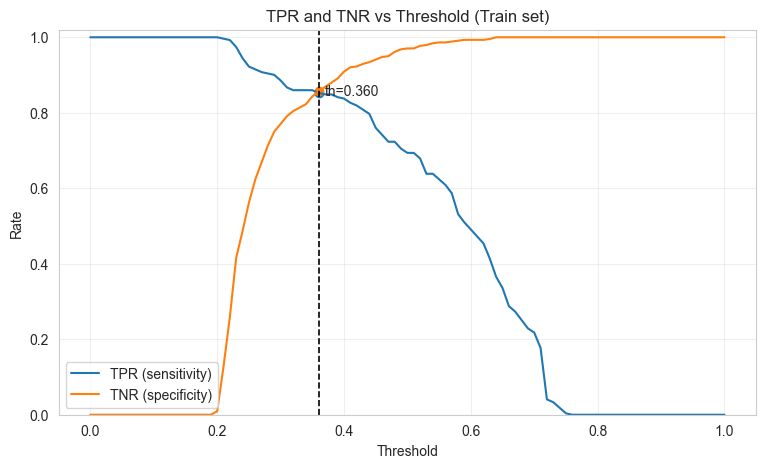

Intersection threshold (closest): 0.360  —  TPR=0.852, TNR=0.857


In [13]:
# Plot TPR and TNR across thresholds using the TRAIN set
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predicted probabilities on the train set
y_proba_train = clf.predict_proba(X_train)[:, 1]
thresholds = np.linspace(0.0, 1.0, 101)

tprs = []
tnrs = []
for t in thresholds:
    y_pred_t = (y_proba_train >= t).astype(int)
    cm = confusion_matrix(y_train, y_pred_t, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    tprs.append(tpr)
    tnrs.append(tnr)

tprs = np.array(tprs)
tnrs = np.array(tnrs)

# Find threshold where TPR and TNR are closest (intersection)
idx = np.nanargmin(np.abs(tprs - tnrs))
intersection_thresh = thresholds[idx]

# Plot
plt.figure(figsize=(9, 5))
plt.plot(thresholds, tprs, label='TPR (sensitivity)', color='tab:blue')
plt.plot(thresholds, tnrs, label='TNR (specificity)', color='tab:orange')
plt.axvline(intersection_thresh, color='k', linestyle='--', linewidth=1.2)
# Mark the intersection points
plt.scatter([intersection_thresh], [tprs[idx]], color='tab:blue')
plt.scatter([intersection_thresh], [tnrs[idx]], color='tab:orange')
# Annotate
val_y = max(tprs[idx], tnrs[idx])
plt.text(intersection_thresh + 0.01, val_y, f'th={intersection_thresh:.3f}', va='center')

plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and TNR vs Threshold (Train set)')
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(0, 1.02)
plt.show()

print(f'Intersection threshold (closest): {intersection_thresh:.3f}  —  TPR={tprs[idx]:.3f}, TNR={tnrs[idx]:.3f}')
threshold = intersection_thresh

In [17]:
# Predict on the test set using the TRAIN-derived threshold when available, then export PassengerId and Survived
if 'clf' in globals() and 'X_test' in globals():
    # Predict probabilities when available
    if hasattr(clf, 'predict_proba'):
        proba = clf.predict_proba(X_test)[:, 1]
        test_data['Survived_proba'] = proba
        # Use threshold computed in the plotting cell if present, else default to 0.5
        th = globals().get('threshold', 0.5)
        preds = (proba >= th).astype(int)
        print(f"Using threshold={th:.3f} for prediction (from train set if available).")
    else:
        preds = clf.predict(X_test)

    test_data['Survived'] = preds.astype(int)

    # Ensure no duplicate/typo column remains
    if 'Survuved' in test_data.columns:
        test_data.drop(columns=['Survuved'], inplace=True)

    # Prepare export dataframe with PassengerId and Survived
    if 'PassengerId' in test_data.columns:
        export_df = test_data[['PassengerId', 'Survived']].copy()
    else:
        # Fallback: use index as PassengerId and warn
        print("Warning: 'PassengerId' not found in test_data; using dataframe index as PassengerId.")
        export_df = test_data[['Survived']].copy()
        export_df.insert(0, 'PassengerId', test_data.index)

    out_path = 'test_predictions_xgb.csv'
    export_df.to_csv(out_path, index=False)

    print(f"Exported predictions to '{out_path}' with columns: {list(export_df.columns)}")
    print(export_df.head().to_string())
else:
    missing = [n for n in ('clf', 'X_test') if n not in globals()]
    print('Missing required objects:', ', '.join(missing))

Using threshold=0.500 for prediction (from train set if available).
Exported predictions to 'test_predictions_xgb.csv' with columns: ['PassengerId', 'Survived']
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


In [64]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     418 non-null    int64  
 1   Pclass          418 non-null    int64  
 2   Sex             418 non-null    int64  
 3   Age             418 non-null    float64
 4   SibSp           418 non-null    int64  
 5   Parch           418 non-null    int64  
 6   Fare            418 non-null    float64
 7   Embarked        418 non-null    int64  
 8   Adult           418 non-null    Int64  
 9   Survived        418 non-null    int64  
 10  Survuved        418 non-null    int64  
 11  Survived_proba  418 non-null    float64
dtypes: Int64(1), float64(3), int64(8)
memory usage: 39.7 KB
